# Options in R

This is a short example of implementing the **binomial option model** and the **Longstaff-Schwartz** method in `R`, all the examples are identical to the **Excel** examples from the lecture notes.

## The binomial option pricing model

The tree from the lecture slides was:

ERROR: 

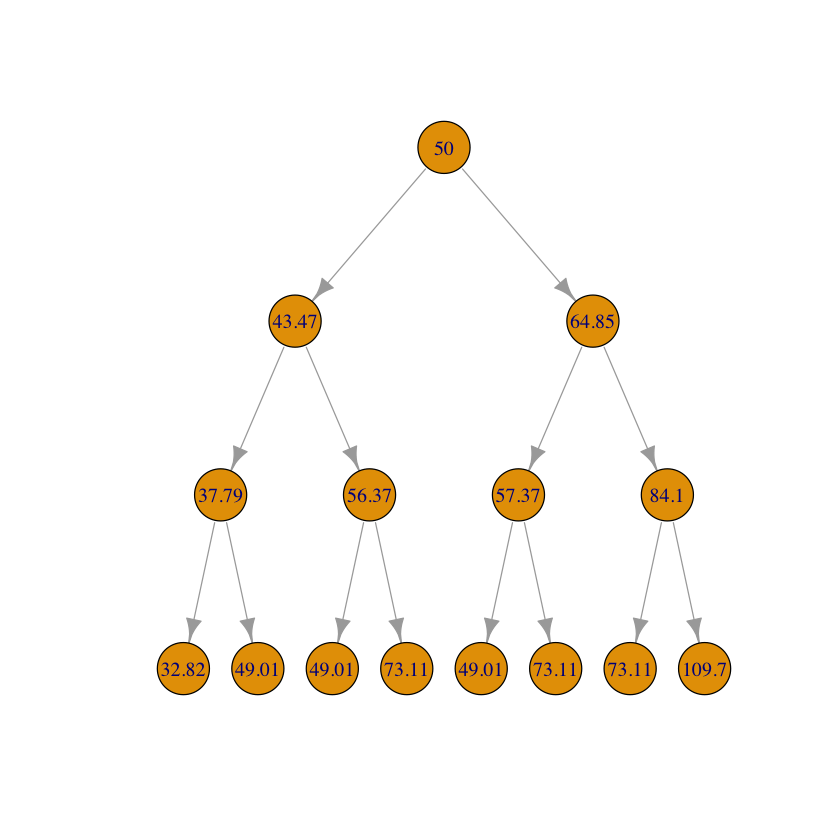

In [2]:
library(igraph)

g = graph.tree(15, 2)
plot(g, layout = layout.reingold.tilford(g, root=1), vertex.label = c(
  50, 43.47, 64.85, 37.79, 56.37, 57.37, 84.1,
  32.82, 49.01, 49.01, 73.11, 49.01, 73.11, 73.11, 109.7), vertex.size=20)

First, we need a suitable (recursive) data structure that easily let us traverse the tree.

In `R` we can create this ad hoc as a nested `list`. We'll store the stock price (node) as element number one (`node`), the left child as number two (`left`) and the right child as element number 3 (`right`)

I.e. `list(node, leftchild, rightchild)`

The corresponding list of lists for the tree above is constructed below (formatted for readability)

In [3]:
# Just some convenient constants:
node = 1
left = 2
right = 3

priceTree = list(50, # root
                 list(43.47, # left subtree
                      list(37.79,
                           list(32.85),
                           list(49.01)),
                      list(56.37,
                           list(49.01),
                           list(73.11))
                      ),
                 list(64.85, # right subtree
                      list(56.37,
                           list(49.01),
                           list(73.11)),
                      list(84.10,
                           list(73.11),
                           list(109.7))
                     )
                 )

To make sure we got it right we can traverse the constructed tree [inorder](https://en.wikipedia.org/wiki/Tree_traversal) and check that the output is reasonable

In [4]:
print.tree = function(tree) {
  print(tree[[node]])
  
  if  ( length(tree) == 1 ) return()
  
  print.tree(tree[[left]])
  print.tree(tree[[right]])
  
}
print.tree(priceTree)

[1] 50
[1] 43.47
[1] 37.79
[1] 32.85
[1] 49.01
[1] 56.37
[1] 49.01
[1] 73.11
[1] 64.85
[1] 56.37
[1] 49.01
[1] 73.11
[1] 84.1
[1] 73.11
[1] 109.7


NULL

Which makes sense (if you compare the output to the original tree)

### Calculating the  European put price

The algorithm described in the lecture notes have two basic steps 1) Compute the option value at each final node, 2) Trace back and compute the binomial value at each point in time.

This is a perfect candidate for [recursion](https://en.wikipedia.org/wiki/Recursion_(computer_science).

In the base case we are at the final node, and return the option payoff `Max(K - price, 0)`

In the recursive case we compute the binomial value `PiExpected = exp(-r) (pd * PiDown + (1 - pd) * PiUp)`

We take four inputs, the strike (`K`), the risk free rate (`r`), the probability of a down tick (`pd`) and the number of periods (`T`, the depth of the tree), and the tree itself (`tree`). The default initialized `t` is just an accumulator to notify us that we hit a leaf node (we could insert a `null` token at the leaf of the tree and check for this instead, but this is a bit simpler)

In [5]:
eput = function(K, r, pd, tree, T, t=0) {
    if (t == T) {
        price = tree[[node]]
        Pi = max(K - price, 0)
        
        return (Pi)
    }

    PiDown = eput(K, r, pd, tree[[left]], T, t + 1)
    PiUp = eput(K, r, pd, tree[[right]], T, t + 1)
    PiExpected = exp(-r) * (pd * PiDown + (1 - pd) * PiUp)
    
    PiExpected
}

The parameters from the lecture where

In [6]:
K = 50
r = .06
pd = .55
T = 3

which gives a price of

In [7]:
eput(K, r, pd, priceTree, T)

[1] 2.720995

The **American put** differs in only one place: we have to check if it is optimal to excersice early

This means that in each recursive case we return the maximum of the current payoff, and the expected continuation
payoff: `max(Pi, PiExpected)`

In [8]:
aput = function(K, r, pd, tree, T, t=0) {
    price = tree[[node]]
    Pi = max(K - price, 0)

    if (t == T) return (Pi)

    PiDown = aput(K, r, pd, tree[[left]], T, t + 1)
    PiUp = aput(K, r, pd, tree[[right]], T, t + 1)
    PiExpected = exp(-r) * (pd * PiDown + (1 - pd) * PiUp)
    
    max(Pi, PiExpected)  
}

which gives a slightly higher price

In [9]:
aput(K, r, pd, priceTree, T)

[1] 3.500991

### Notes

* Instead of computing the tree ahead of time and storing it, we could just compute the stock price at each leaf node [as we go](https://en.wikipedia.org/wiki/Binomial_options_pricing_model#STEP_1:_Create_the_binomial_price_tree)

* What we have implemented is a naive algorithm: for a tree with T nodes we will have to evaulate $2^T$ nodes. With for example 64 time steps, if your computer could evaluate 1 billion nodes per second, this proceudre would take more than 500 years to finish. For a very cool article on how to speed this up to quadratic runtime with the Fast Fourier Transform, look [here](http://andrew.gibiansky.com/blog/economics/accelerating-options-pricing-via-fourier-transforms/)

##  Longstaff-Schwartz

The *Longstaff-Schwartz* method lets us calculate the American put price in [polynomial time](http://mathworld.wolfram.com/PolynomialTime.html)

First we need some simulated paths for the stock price over the 3 periods.

The stock from the lecture the stock followed a [Geometric Brownian motion](https://en.wikipedia.org/wiki/Geometric_Brownian_motion). Finding the solution to this diffusion process is just a straightforward application of [Ito's lemma](https://en.wikipedia.org/wiki/It%C3%B4%27s_lemma):

$s_t = s_0 \exp((\mu - \frac{\sigma^2}{2})t + \sigma \sqrt{t} u)$,

where $u$ is standard normal.

For matrices the `*` operator is the [Hadamard](https://en.wikipedia.org/wiki/Hadamard_product_(matrices) product in `R`, so we can calculate `N` simulated paths over `T` periods in one go:

In [10]:
gbm = function(s0, mu, sigma, N, T) {
    t = t(replicate(N, 1:T))
    N  = matrix(rnorm(T * N), N)
    
    s0 * exp((mu - sigma^2 / 2) * t + sigma * sqrt(t) * N)
}

With the same parameters as in the lecture this gives us

In [11]:
data = gbm(50, .06, .15, 5000, 3)
head(data)

50.97640,46.11763,73.44386
52.24736,67.92825,67.27507
54.39625,39.79971,92.40321
39.50353,46.17004,35.29642
50.46548,35.10799,79.01262
54.27193,64.43070,56.73312


Next, in implementing the *Longstaff-Schwartz* method, we start at the last period `T`, compute the payoff for each path, and store them in a `NxT` matrix containing our optimal decisions `optDes` (note that we use `pmax` instead of `max` for the elementwise max of two vectors)

We then iterate backwards trough time and 

* Regress the discounted optimal payoffs one period ahead (`optDes[, t+1]`) on the current stock price, and obtain the fitted values `PiExpected`, which is our expected continuation payoff.

* Compare this with the payoff of exercising now (`Pi`)

* If these are greater than the continuation profit, store them in the current column of our optimal decision matrix.
If not, store the discounted, payoff one year ahead.

At the end our time 0 value is just the mean of the discounted values in column 1 of our payoff matrix.

In [12]:
LSput = function(K, r, T, data) {
    n = nrow(data)
    optDes = matrix(0, nrow=n, ncol=T)
    optDes[, T] = pmax(K - data[, T], 0)

    for (t in (T-1):1) {
        stockPrice = data[, t]
        stockPricesq = stockPrice ^ 2

        Pi = pmax(K - stockPrice, 0)
        PiExpected = lm(exp(-r) * optDes[, t+1] ~
                        stockPrice + stockPricesq
                        )$fitted.values

        optDes[, t] = ifelse(Pi > PiExpected,
                        Pi,
                        exp(-r) * optDes[, t+1])
    }
    mean(exp(-r) * optDes[, 1])
}

which gives a put price of (which should be very close to the one from the lecture notes)

In [13]:
LSput(K, r, T, data)

[1] 3.688597